# **Netflix Recommendation Engine**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Reading dataset file
netflix_dataset = pd.read_csv('/content/drive/MyDrive/Data Science Intellipat (MIT)/Copy of combined_data_1.txt.zip',header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
netflix_dataset


,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


In [ ]:
netflix_dataset.isnull().sum()

Cust_Id       0
Rating     4499
dtype: int64

In [6]:
#get the movie count with NaN values
movie_count = netflix_dataset.isnull().sum()
movie_count = movie_count['Rating']
movie_count

4499

In [4]:
#to claculate how many customers we are having in the dataset
customer_count=netflix_dataset['Cust_Id'].nunique()

In [7]:
customer_count=customer_count- movie_count

In [8]:
customer_count

470758

In [9]:
#get the total number of ratings given by the customers
rating_count=len(netflix_dataset)-movie_count
rating_count

24053764

In [10]:
#To find out how many people have rated the movies as 1, 2, 3,4,5 stars ratings to the movies
stars=netflix_dataset.groupby('Rating')['Rating'].agg(['count'])

In [11]:
stars

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


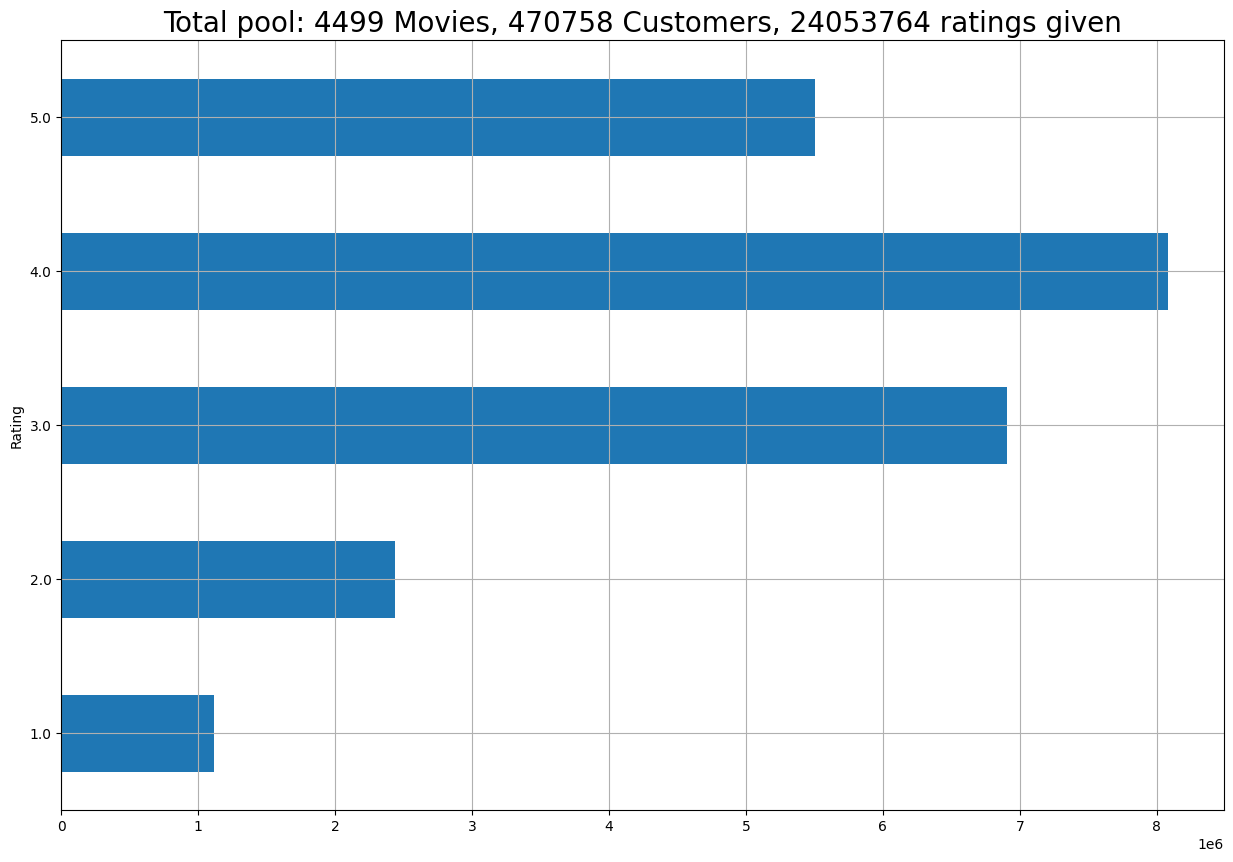

In [12]:
ax=stars.plot(kind='barh', legend=False, figsize=(15,10))
plt.title(f'Total pool: {movie_count} Movies, {customer_count} Customers, {rating_count} ratings given', fontsize=20)
plt.grid(True)

In [13]:
#first of all we will be calculating how many null values we are having in the ratings column
df_nan=pd.DataFrame(pd.isnull(netflix_dataset.Rating))

In [14]:
df_nan

,Rating
0,True
1,False
2,False
3,False
4,False
...,...
24058258,False
24058259,False
24058260,False
24058261,False


In [15]:
df_nan=df_nan[df_nan['Rating']==True]
df_nan

,Rating
0,True
548,True
694,True
2707,True
2850,True
...,...
24046714,True
24047329,True
24056849,True
24057564,True


In [16]:
#now we will reset the index as the column
df_nan=df_nan.reset_index()

In [17]:
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [18]:
#now we will create a numpy array that will contain 1 from values 0 to 547, 2 from 549 to 693 and so on
movie_np=[]
movie_id=1
for i, j in zip(df_nan['index'][1:], df_nan['index'][:-1]):
    temp=np.full((1, i-j-1), movie_id)
    movie_np=np.append(movie_np, temp)
    movie_id+=1

#account for last record and corresponding length
#numpy approach
last_record=np.full((1, len(netflix_dataset)-df_nan.iloc[-1,0]-1), movie_id)#movie id will be 4499
movie_np=np.append(movie_np, last_record)

In [20]:
netflix_dataset.iloc[543:900,:]

,Cust_Id,Rating,Movie_Id
544,1403184,3.0,1
545,1535440,4.0,1
546,1426604,4.0,1
547,1815755,5.0,1
549,2059652,4.0,2
...,...,...,...
898,1213801,3.0,3
899,1045221,1.0,3
900,253037,3.0,3
901,341954,2.0,3


In [ ]:
# Pre - filtering of the data before recomendation

In [21]:
dataset_movie_summary=netflix_dataset.groupby('Movie_Id')['Rating'].agg(["count"])

In [22]:
dataset_movie_summary

,count
Movie_Id,
1,547
2,145
3,2012
4,142
5,1140
...,...
4495,614
4496,9519
4497,714


In [23]:
#now we will remove all the users that are in-active
dataset_cust_summary=netflix_dataset.groupby('Cust_Id')['Rating'].agg(["count"])
dataset_cust_summary

,count
Cust_Id,
6,153
7,195
8,21
10,49
25,4
...,...
2649404,12
2649409,10
2649421,3


In [28]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357250 sha256=efbb82a28e8e25dd9cd556d0285f7fae72801e04d72e3d18e9def47c7d65bea8
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [70]:
import pandas as pd
import math
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


In [71]:
# Step 1: Load the movie titles
df_title = pd.read_csv("/content/drive/MyDrive/Data Science Intellipat (MIT)/Copy of movie_titles.csv", encoding='ISO-8859-1', header=None, usecols=[0,1,2], names=['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace=True)

In [72]:
# Step 2: Load the genres data
df_genres = pd.read_csv("/content/drive/MyDrive/Data Science Intellipat (MIT)/Copy of movie_titles.csv", encoding='ISO-8859-1', usecols=[0, 1], names=['Movie_Id', 'Genre'])

In [74]:
reader = Reader(rating_scale=(1, 5))
data=Dataset.load_from_df(netflix_dataset[:100000], reader)

In [75]:
# Step 4: Train the SVD model
model = SVD()
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    18.2657 18.2619 18.2968 18.2748 0.0156  
MAE (testset)     16.3148 16.2981 16.3606 16.3245 0.0264  
Fit time          1.81    1.84    1.96    1.87    0.06    
Test time         0.26    0.45    0.46    0.39    0.09    


{'test_rmse': array([18.26566914, 18.26191354, 18.2967656 ]),
 'test_mae': array([16.31479819, 16.29812415, 16.3605854 ]),
 'fit_time': (1.8052303791046143, 1.84074068069458, 1.957329511642456),
 'test_time': (0.26482582092285156, 0.44518446922302246, 0.457963228225708)}

In [76]:
# Step 5: Merging the genres information with the original dataframe
df_merged = pd.merge(netflix_dataset, df_genres, left_on='Movie_Id', right_on='Movie_Id')


In [77]:
# Step 6: Finding the average rating per genre
genre_ratings = df_merged.groupby('Genre')['Rating'].mean().sort_values(ascending=False)

In [89]:
#Recommendation
netflix_dataset

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [90]:
print("Average ratings per genre:")
print(genre_ratings)
print(df_title.copy)

Average ratings per genre:
Genre
1939.0    4.094602
1954.0    4.067926
1974.0    4.066583
1959.0    4.012644
1938.0    3.971284
            ...   
1922.0    3.260204
1918.0    3.230769
1932.0    3.201018
1921.0    3.058462
1926.0    2.906542
Name: Rating, Length: 89, dtype: float64
<bound method NDFrame.copy of             Year                                               Name
Movie_Id                                                           
1         2003.0                                    Dinosaur Planet
2         2004.0                         Isle of Man TT 2004 Review
3         1997.0                                          Character
4         1994.0                       Paula Abdul's Get Up & Dance
5         2004.0                           The Rise and Fall of ECW
...          ...                                                ...
17766     2002.0  Where the Wild Things Are and Other Maurice Se...
17767     2004.0                  Fidel Castro: American Experience
17768  

In [86]:
#take user 1331154 and recommend some movies based on the past data
user_1331154=df_title.copy()
user_1331154

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17767,2004.0,Fidel Castro: American Experience
17768,2000.0,Epoch


In [88]:
# Step 8: Finding genres with the best and worst ratings
print("Best rated genres:")
print(df_title.copy().head())

print("Worst rated genres:")
print(df_title.copy().tail())

Best rated genres:
            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
Worst rated genres:
            Year                                               Name
Movie_Id                                                           
17766     2002.0  Where the Wild Things Are and Other Maurice Se...
17767     2004.0                  Fidel Castro: American Experience
17768     2000.0                                              Epoch
17769     2003.0                                        The Company
17770     2003.0                                       Alien Hunter
